In this case, the Automobile Data set is an online source, and it is in a CSV (comma separated value) format.

* Data source: https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data
* Data type: csv

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#load the data into a dataframe
filepath = 'https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data'
df = pd.read_csv(filepath, header=None)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [3]:
#add header to the dataframe
header = ["symboling","normalized-losses","make","fuel-type","aspiration", "num-of-doors","body-style","drive-wheels","engine-location","wheel-base", "length","width","height","curb-weight","engine-type","num-of-cylinders", "engine-size","fuel-system","bore","stroke","compression-ratio","horsepower","peak-rpm","city-mpg","highway-mpg","price"]
df.columns = header

#**Identify missing values**
###**Convert "?" to NaN**
In the car data set, missing data comes with the question mark "?". We replace "?" with NaN (Not a Number), Python's default missing value marker for reasons of computational speed and convenience.

In [4]:
#replace the "?" symbol with NaN so the dropna() can remove the missing values
df.replace("?", np.nan, inplace = True)
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [5]:
#count missing values in every column
missing_data = df.isnull()
for col in missing_data.columns:
  print(missing_data[col].value_counts())
  print(" ")

symboling
False    205
Name: count, dtype: int64
 
normalized-losses
False    164
True      41
Name: count, dtype: int64
 
make
False    205
Name: count, dtype: int64
 
fuel-type
False    205
Name: count, dtype: int64
 
aspiration
False    205
Name: count, dtype: int64
 
num-of-doors
False    203
True       2
Name: count, dtype: int64
 
body-style
False    205
Name: count, dtype: int64
 
drive-wheels
False    205
Name: count, dtype: int64
 
engine-location
False    205
Name: count, dtype: int64
 
wheel-base
False    205
Name: count, dtype: int64
 
length
False    205
Name: count, dtype: int64
 
width
False    205
Name: count, dtype: int64
 
height
False    205
Name: count, dtype: int64
 
curb-weight
False    205
Name: count, dtype: int64
 
engine-type
False    205
Name: count, dtype: int64
 
num-of-cylinders
False    205
Name: count, dtype: int64
 
engine-size
False    205
Name: count, dtype: int64
 
fuel-system
False    205
Name: count, dtype: int64
 
bore
False    201
True       4
Na

From the summary above we can see that each column contains 205 entries of data. It can be noted than 7 columns contain missing data:
- Normalized-losses: 41
- Num-of-doors: 2
- Bore: 4
- Stroke: 4
- Horse-power: 2
- Peak-rpm: 2
- Price: 4

##**Dealing with missing values**

###**Droping rows**
Since we want to predict prices, we can't use entries without price data for prediction.
For the column "price", we'll delete the rows for missing data

In [6]:
#drop entire rows with missing values along the column price
df.dropna(subset=["price"], axis=0, inplace=True)

###**Replace by mean**
We replace missing values from the columns "normalized-losses", "bore", "stroke", "horse-power", "peak-rpm".

In [7]:
#calculate the mean values for the above columns
#normalized-loss mean
norm_loss_avg = df["normalized-losses"].astype("float").mean(axis=0)
#bore mean
bore_avg = df['bore'].astype('float').mean(axis=0)
#stroke mean
stroke_avg = df['stroke'].astype('float').mean(axis=0)
#horsepower mean
horsepow_avg = df['horsepower'].astype('float').mean(axis=0)
#peak rpm mean
peakrpm_avg = df['peak-rpm'].astype('float').mean(axis=0)

print("Normalized-losses avg: ", norm_loss_avg)
print("Bore avg: ", bore_avg)
print("Stroke avg: ", stroke_avg)
print("Horsepower avg: ", horsepow_avg)
print("Peak rpm avg: ", peakrpm_avg)

Normalized-losses avg:  122.0
Bore avg:  3.330710659898477
Stroke avg:  3.256903553299492
Horsepower avg:  103.39698492462311
Peak rpm avg:  5117.587939698493


In [8]:
#replace "NaN" with the mean values above
#normalized-losses
df["normalized-losses"].replace(np.nan, norm_loss_avg, inplace=True)
#bore
df['bore'].replace(np.nan, bore_avg, inplace=True)
#stroke
df['stroke'].replace(np.nan, stroke_avg, inplace=True)
#horsepower
df['horsepower'].replace(np.nan, horsepow_avg, inplace=True)
#peak rpm
df['peak-rpm'].replace(np.nan, peakrpm_avg, inplace=True)

###**Replace by frequency**
For the column "num-of-doors" we check for the values present and replace the missing values with the most frequently occuring value.

In [9]:
#check the values present in the column "num-of-doors"
df['num-of-doors'].value_counts()

,count
num-of-doors,
four,113
two,86


In [10]:
#replace the missing data with the most common value i.e four
comm_num_doors = df['num-of-doors'].value_counts().idxmax()
df['num-of-doors'].replace(np.nan, comm_num_doors, inplace=True)

In [11]:
#count missing values in every column after handling missing data
missing_data = df.isnull()
for col in missing_data.columns:
  print(missing_data[col].value_counts())
  print(" ")

symboling
False    201
Name: count, dtype: int64
 
normalized-losses
False    201
Name: count, dtype: int64
 
make
False    201
Name: count, dtype: int64
 
fuel-type
False    201
Name: count, dtype: int64
 
aspiration
False    201
Name: count, dtype: int64
 
num-of-doors
False    201
Name: count, dtype: int64
 
body-style
False    201
Name: count, dtype: int64
 
drive-wheels
False    201
Name: count, dtype: int64
 
engine-location
False    201
Name: count, dtype: int64
 
wheel-base
False    201
Name: count, dtype: int64
 
length
False    201
Name: count, dtype: int64
 
width
False    201
Name: count, dtype: int64
 
height
False    201
Name: count, dtype: int64
 
curb-weight
False    201
Name: count, dtype: int64
 
engine-type
False    201
Name: count, dtype: int64
 
num-of-cylinders
False    201
Name: count, dtype: int64
 
engine-size
False    201
Name: count, dtype: int64
 
fuel-system
False    201
Name: count, dtype: int64
 
bore
False    201
Name: count, dtype: int64
 
stroke
False 

Now our data is free of missing data

##**Correct data format**


In [12]:
#list data format for all columns
df.dtypes

,0
symboling,int64
normalized-losses,object
make,object
fuel-type,object
aspiration,object
num-of-doors,object
body-style,object
drive-wheels,object
engine-location,object
wheel-base,float64


From the summary above we can see that some columns are not of the correct data types. Numerical variables should be type 'int' or 'float' while string variable should have type 'object'.



In [13]:
#correct data types to the right format
df[['price']] = df[['price']].astype('float')
df[['peak-rpm']] = df[['peak-rpm']].astype('float')
df[['horsepower']] = df[['horsepower']].astype('int')
df[['stroke']] = df[['stroke']].astype('float')
df[['bore']] = df[['bore']].astype('float')
df[['normalized-losses']] = df[['normalized-losses']].astype('int')

In [14]:
#list data formats for each column after correction
df.dtypes

,0
symboling,int64
normalized-losses,int64
make,object
fuel-type,object
aspiration,object
num-of-doors,object
body-style,object
drive-wheels,object
engine-location,object
wheel-base,float64


##**Data standardization**
The fuel consumption columns "city-mpg" and "highway-mpg" are represented by mpg (miles per gallon) unit. In this case, we are developing an application in a country that accepts the fuel consumption with L/100km standard.

We need to apply data transformation to transform mpg into L/100km.

Therefore we will use this formula for unit conversion:

L/100km = 235 / mpg

In [15]:
#convert mpg to L/100km
df['city-mpg'] = 235/df['city-mpg']
df['highway-mpg'] = 235/df['highway-mpg']
#rename the column to "city-L/100km" and "highway-L/100km"
df.rename(columns={'city-mpg':'city-L/100km', 'highway-mpg':'highway-L/100km'}, inplace=True)

In [ ]:
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-L/100km,highway-L/100km,price
0,3,122,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000.0,11.190476,8.703704,13495.0
1,3,122,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000.0,11.190476,8.703704,16500.0
2,1,122,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000.0,12.368421,9.038462,16500.0
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500.0,9.791667,7.833333,13950.0
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500.0,13.055556,10.681818,17450.0


##**Data Normalization**
Let's scale the columns "length", "width" and "height" so their value ranges from 0 to 1

**Approach:** replace the original value by (original value)/(maximum value)

In [16]:
#replace the original value by (original value)/(maximum value)
df['length'] = df['length']/df['length'].max()
df['width'] = df['width']/df['width'].max()
df['height'] = df['height']/df['height'].max()

Now we've normalized "length", "width" and "height" to fall in the range of [0,1].

##**Binning**
In our data set, "horsepower" is a real valued variable ranging from 48 to 288 and it has 59 unique values.Since we only care about the price difference between cars with high horsepower, medium horsepower, and little horsepower, we can rearrange them into three groups (bins) to simplify analysis.

Text(0.5, 1.0, 'horsepower bins')

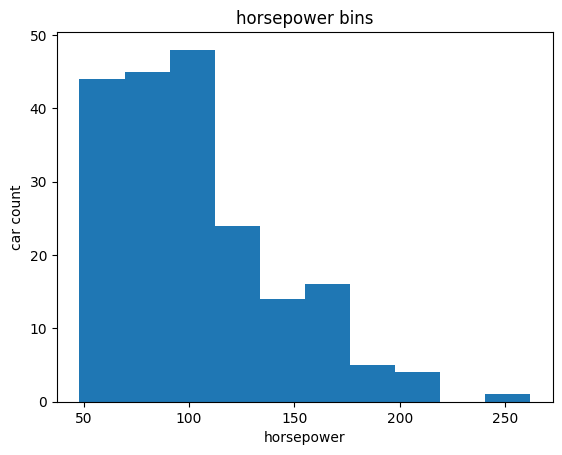

In [19]:
#plot histogram to see distribution of horsepower
plt.hist(df['horsepower'])

#set x and y label as well as title
plt.xlabel('horsepower')
plt.ylabel('car count')
plt.title('horsepower bins')

In [20]:
#create a bin array with a minimum value to a maximum value and 4 numbers generated
bins = np.linspace(df['horsepower'].min(),df['horsepower'].max(),4)
bins

array([ 48.        , 119.33333333, 190.66666667, 262.        ])

In [21]:
#set group names
group_names = ['Low', 'Medium', 'High']

In [22]:
#group the horsepower as either low, medium or high
df['horsepower-binned'] = pd.cut(df['horsepower'], bins, labels=group_names, include_lowest=True)
df[['horsepower', 'horsepower-binned']].head(20)

,horsepower,horsepower-binned
0,111,Low
1,111,Low
2,154,Medium
3,102,Low
4,115,Low
5,110,Low
6,110,Low
7,110,Low
8,140,Medium
10,101,Low


From the data frame above you will find that the last column provides the bins for "horsepower" based on 3 categories ("Low", "Medium" and "High"). We have successfully narrowed down the intervals from 59 to 3!

Text(0.5, 1.0, 'horsepower bins')

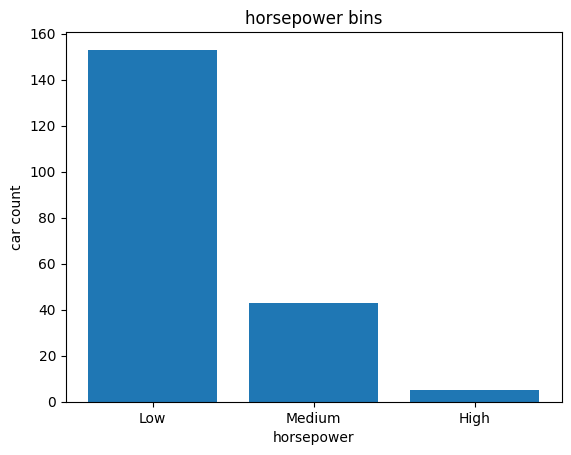

In [23]:
#plot the distribution of each bin
plt.bar(group_names, df['horsepower-binned'].value_counts())

#set x and y label as well as title
plt.xlabel('horsepower')
plt.ylabel('car count')
plt.title('horsepower bins')

In [24]:
#see number of vehicles in each bin
df['horsepower-binned'].value_counts()

,count
horsepower-binned,
Low,153
Medium,43
High,5


Text(0, 0.5, 'car count')

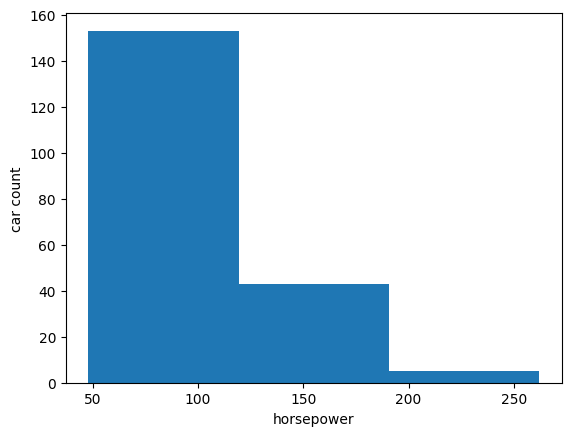

In [25]:
#plot a histogram of attribute horsepower with bins=3
plt.hist(df['horsepower'], bins=3)

#set x and y label as well as title
plt.xlabel('horsepower')
plt.ylabel('car count')

##**Indicator variables**
The column "fuel-type" has two unique values: "gas" or "diesel". Regression doesn't understand words, only numbers. To use this attribute in regression analysis, we will convert "fuel-type" to indicator variables.

In [26]:
#get the indicator variables
ind_var_fuel = pd.get_dummies(df['fuel-type'])
#changre the column name for clarity
ind_var_fuel.rename(columns={'gas':'fuel-type-gas', 'diesel':'fuel-type-diesel'}, inplace=True)
ind_var_fuel.head()

,fuel-type-diesel,fuel-type-gas
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True


In [27]:
#merge the dataframes 'df' and 'ind_var_fuel'
df = pd.concat([df,ind_var_fuel], axis=1)

#drop the original column "fuel-type"
df.drop('fuel-type-diesel', axis=1, inplace=True)

In [ ]:
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,bore,stroke,compression-ratio,horsepower,peak-rpm,city-L/100km,highway-L/100km,price,horsepower-binned,fuel-type-gas
0,3,122,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,3.47,2.68,9.0,111,5000.0,11.190476,8.703704,13495.0,Low,True
1,3,122,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,3.47,2.68,9.0,111,5000.0,11.190476,8.703704,16500.0,Low,True
2,1,122,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,2.68,3.47,9.0,154,5000.0,12.368421,9.038462,16500.0,Medium,True
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,3.19,3.40,10.0,102,5500.0,9.791667,7.833333,13950.0,Low,True
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,3.19,3.40,8.0,115,5500.0,13.055556,10.681818,17450.0,Low,True


We'll do the same for the column "aspiration"

In [28]:
#get the indicator variable
ind_var_asp = pd.get_dummies(df['aspiration'])
# rename the columns
ind_var_asp.rename(columns={'std':'aspiration-std', 'turbo':'aspiration-turbo'}, inplace=True)
#merge the dataframes 'df' and 'ind_var_asp'
df = pd.concat([df, ind_var_asp], axis=1 )
#drop the original column 'aspiration'
df.drop('aspiration', axis=1, inplace=True)

In [ ]:
df.head()

,symboling,normalized-losses,make,fuel-type,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,compression-ratio,horsepower,peak-rpm,city-L/100km,highway-L/100km,price,horsepower-binned,fuel-type-gas,aspiration-std,aspiration-turbo
0,3,122,alfa-romero,gas,two,convertible,rwd,front,88.6,0.811148,...,9.0,111,5000.0,11.190476,8.703704,13495.0,Low,True,True,False
1,3,122,alfa-romero,gas,two,convertible,rwd,front,88.6,0.811148,...,9.0,111,5000.0,11.190476,8.703704,16500.0,Low,True,True,False
2,1,122,alfa-romero,gas,two,hatchback,rwd,front,94.5,0.822681,...,9.0,154,5000.0,12.368421,9.038462,16500.0,Medium,True,True,False
3,2,164,audi,gas,four,sedan,fwd,front,99.8,0.848630,...,10.0,102,5500.0,9.791667,7.833333,13950.0,Low,True,True,False
4,2,164,audi,gas,four,sedan,4wd,front,99.4,0.848630,...,8.0,115,5500.0,13.055556,10.681818,17450.0,Low,True,True,False


In [ ]:
df.to_csv('clean_automobile.csv', index=False)

## **Continuous Numerical Variables**
In order to start understanding the (linear) relationship between an individual variable and the price, we can use "regplot" which plots the scatterplot plus the fitted regression line for the data. This will be useful later on for visualizing the fit of the simple linear regression model as well.



###**Positive linear relationship**
Let's find the scatterplot of "engine-size" and "price".

(0.0, 53554.27581972356)

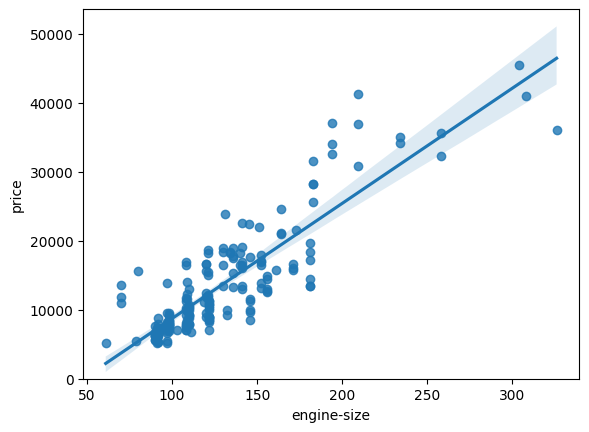

In [29]:
#engine size as a posible price predictor variable
sns.regplot(x="engine-size", y="price", data=df)
plt.ylim(0,)

As the engine-size goes up, the price goes up: this indicates a positive direct correlation between these two variables

In [30]:
df[['engine-size','price']].corr()

,engine-size,price
engine-size,1.000000,0.872335
price,0.872335,1.000000


We can examine the correlation between 'engine-size' and 'price' and see that it's approximately 0.87.


Highway mpg is a potential predictor variable of price. Let's find the scatterplot of "highway-L/100km" and "price".


(0.0, 47710.95305567811)

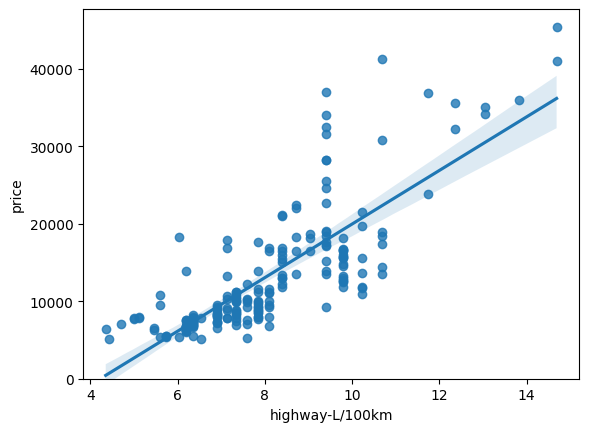

In [31]:
sns.regplot(x="highway-L/100km", y="price", data=df)
plt.ylim(0,)

As highway-L/100km goes up, the price goes up: this indicates a positive relationship between these two variables. Highway mpg could potentially be a predictor of price.

In [32]:
df[['highway-L/100km','price']].corr()

,highway-L/100km,price
highway-L/100km,1.000000,0.801118
price,0.801118,1.000000


We examine the correlation between 'highway-mpg' and 'price' and see it's approximately 0.801.

###**Weak linear relationship**
Let's see if "peak-rpm" is a predictor variable of "price".

(0.0, 47414.1)

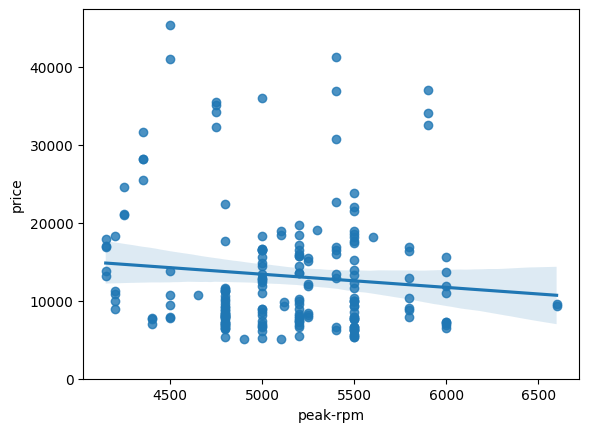

In [33]:
#peak-rpm as a posible price predictor variable
sns.regplot(x="peak-rpm", y="price", data=df)
plt.ylim(0,)

Peak rpm does not seem like a good predictor of the price at all since the regression line is close to horizontal. Also, the data points are very scattered and far from the fitted line, showing lots of variability. Therefore, it's not a reliable variable.

In [34]:
df[["peak-rpm","price"]].corr()

,peak-rpm,price
peak-rpm,1.000000,-0.101542
price,-0.101542,1.000000


We can examine the correlation between 'peak-rpm' and 'price' and see it's approximately -0.101542.

##**Categorical variables**
A good way to visualize categorical variables is by using boxplots.

Let's look at the relationship between "body-style" and "price".

<Axes: xlabel='body-style', ylabel='price'>

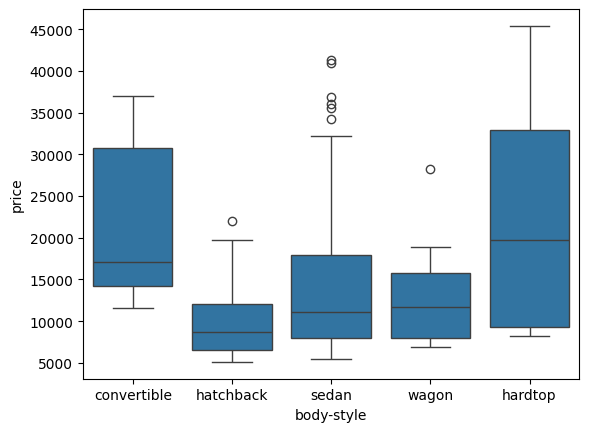

In [35]:
sns.boxplot(x="body-style", y="price", data=df)

We see that the distributions of price between the different body-style categories have a significant overlap, so body-style would not be a good predictor of price. Let's examine engine "engine-location" and "price":

<Axes: xlabel='engine-location', ylabel='price'>

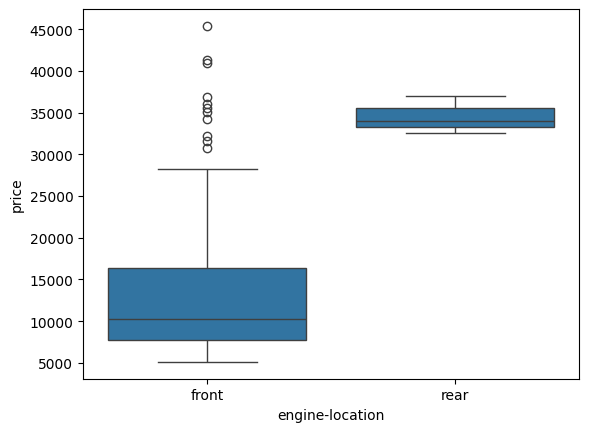

In [36]:
sns.boxplot(x="engine-location", y="price", data=df)

Here we see that the distribution of price between these two engine-location categories, front and rear, are distinct enough to take engine-location as a potential good predictor of price.

Let's examine "drive-wheels" and "price".

<Axes: xlabel='drive-wheels', ylabel='price'>

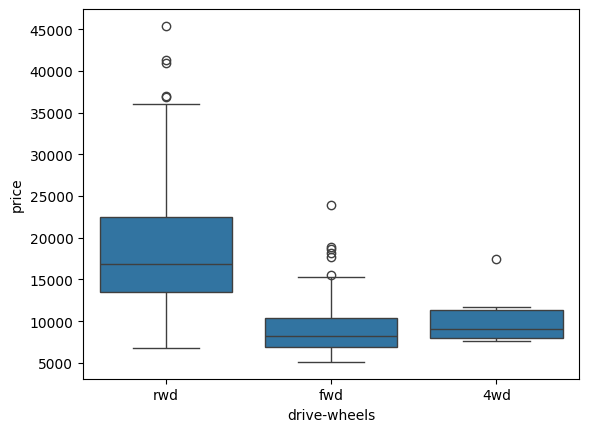

In [37]:
sns.boxplot(x="drive-wheels", y="price", data=df)

Here we see that the distribution of price between the different drive-wheels categories differs. As such, drive-wheels could potentially be a predictor of price.

##**Basics of Grouping**
We want to know, on average, which type of drive wheel is most valuable, we can group "drive-wheels" and then average them.

In [45]:
#select the columns 'drive-wheels' and 'price', then assign it to the variable "df_group_one"
df_group_one = df[['drive-wheels', 'price']]
#calculate the average price for each of the different categories of data
df_grouped = df_group_one.groupby(['drive-wheels'], as_index=False).mean()
df_grouped

,drive-wheels,price
0,4wd,10241.000000
1,fwd,9244.779661
2,rwd,19757.613333


From the result above, we can note that rear-wheel drive vehicles are, on average, the most expensive, while 4-wheel and front-wheel are approximately the same in price.

We can also group by multiple variables. For example, let's group by both 'drive-wheels' and 'body-style'. This groups the dataframe by the unique combination of 'drive-wheels' and 'body-style'. We can store the results in the variable 'grouped_test1'.

In [43]:
df_grptest = df[['drive-wheels','body-style','price']]
grouped_test1 = df_grptest.groupby(['drive-wheels','body-style'], as_index=False).mean()
grouped_test1

,drive-wheels,body-style,price
0,4wd,hatchback,7603.000000
1,4wd,sedan,12647.333333
2,4wd,wagon,9095.750000
3,fwd,convertible,11595.000000
4,fwd,hardtop,8249.000000
5,fwd,hatchback,8396.387755
6,fwd,sedan,9811.800000
7,fwd,wagon,9997.333333
8,rwd,convertible,23949.600000
9,rwd,hardtop,24202.714286


This grouped data is much easier to visualize when it is made into a pivot table. We can convert the dataframe to a pivot table using the method "pivot" to create a pivot table from the groups.

In [47]:
#create a pivot table from the groups with drive-wheels variable as the rows, and pivot body-style as the columns
grp_pivot = grouped_test1.pivot(index='drive-wheels', columns='body-style')
grp_pivot = grp_pivot.fillna(0)
grp_pivot

price                                            \
body-style   convertible       hardtop     hatchback         sedan   
drive-wheels                                                         
4wd                  0.0      0.000000   7603.000000  12647.333333   
fwd              11595.0   8249.000000   8396.387755   9811.800000   
rwd              23949.6  24202.714286  14337.777778  21711.833333   

                            
body-style           wagon  
drive-wheels                
4wd            9095.750000  
fwd            9997.333333  
rwd           16994.222222